<a href="https://www.kaggle.com/code/ahana09/ps-s3e19-pycaret?scriptVersionId=138598288" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import folium
import json
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit 
from catboost import CatBoostRegressor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### View Datasets & Add Features

In [2]:
train=pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
test=pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")
sub=pd.read_csv("/kaggle/input/playground-series-s3e19/sample_submission.csv")

In [3]:
train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [4]:
train.describe()

,id,num_sold
count,136950.00000,136950.000000
mean,68474.50000,165.522636
std,39534.20402,183.691575
min,0.00000,2.000000
25%,34237.25000,46.000000
50%,68474.50000,98.000000
75%,102711.75000,184.000000
max,136949.00000,1380.000000


In [5]:
test.head()

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better


In [6]:
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['weekday'] = train['date'].dt.weekday
train['is_month_start'] = train['date'].dt.is_month_start
train['is_month_end'] = train['date'].dt.is_month_end
train['is_year_start'] = train['date'].dt.is_year_start
train['is_year_end'] = train['date'].dt.is_year_end

In [7]:
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['weekday'] = test['date'].dt.weekday
test['is_month_start'] = test['date'].dt.is_month_start
test['is_month_end'] = test['date'].dt.is_month_end
test['is_year_start'] = test['date'].dt.is_year_start
test['is_year_end'] = test['date'].dt.is_year_end

In [8]:
train=train.drop('id',axis=1)

In [9]:
train.nunique()

date              1826
country              5
store                3
product              5
num_sold          1028
year                 5
month               12
day                 31
weekday              7
is_month_start       2
is_month_end         2
is_year_start        2
is_year_end          2
dtype: int64

In [10]:
train['product'].unique()

array(['Using LLMs to Improve Your Coding',
       'Using LLMs to Train More LLMs',
       'Using LLMs to Win Friends and Influence People',
       'Using LLMs to Win More Kaggle Competitions',
       'Using LLMs to Write Better'], dtype=object)

In [11]:
train['store'].unique()

array(['Kaggle Learn', 'Kaggle Store', 'Kagglazon'], dtype=object)

### EDA

In [12]:
cat_cols=['country', 'store', 'product']

In [13]:
def UVA_category(data, var_group):
  '''
  Univariate Analysis of Categorical Columns
  Takes a list of category and a DataFrame
  Prints/plots all value_counts and barplot
  '''
  #setting figsize
  size = len(var_group)
  plt.figure(figsize=(9*size, 5), dpi=120)

  for j, i in enumerate(var_group):
    #for counting the unique values
    norm_count = data[i].value_counts(normalize=True)
    n_uni = data[i].nunique()

    plt.subplot(1, size, j+1)
    sns.barplot(x=norm_count, y=norm_count.index, order=norm_count.index)
    plt.xlabel(f'Fraction/percent', fontsize=20)
    plt.ylabel(f'{i}', fontsize=10)
    plt.title(f'n_uniques={n_uni}\nValue_counts={norm_count}')

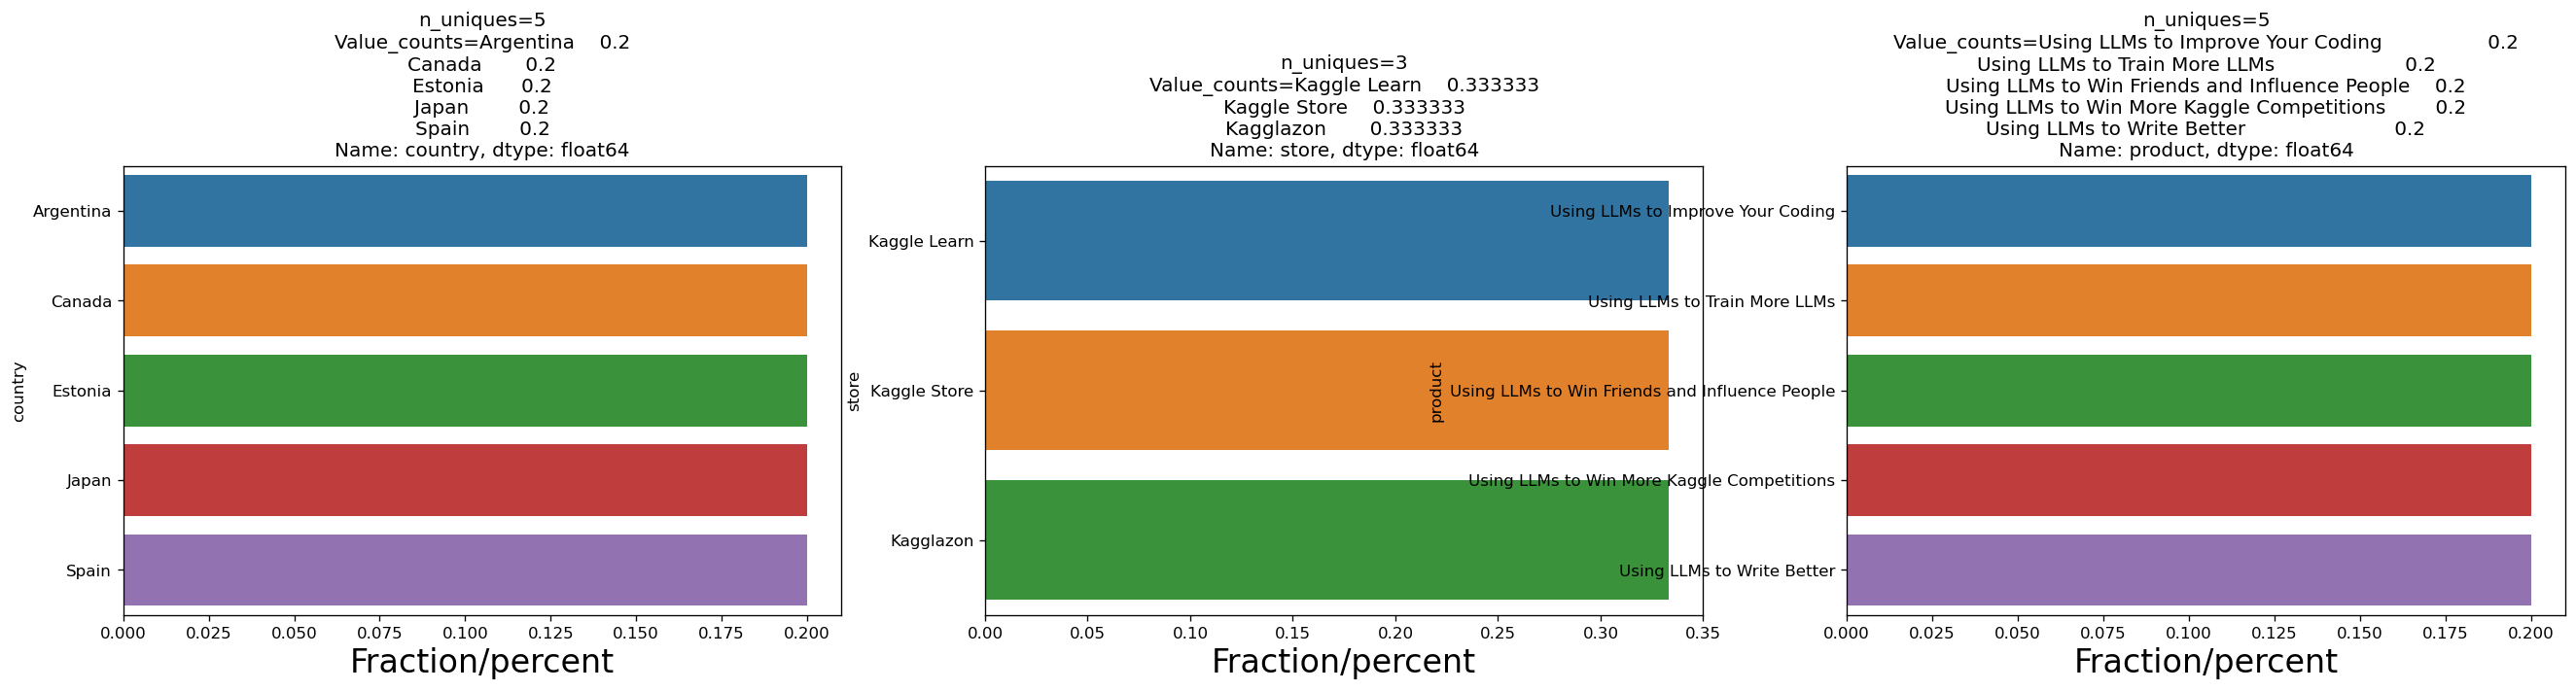

In [14]:
UVA_category(train,cat_cols)

In [15]:
basemap=folium.Map(location=[20,0], zoom_start=2)

In [16]:
country_wise_data = train.copy()
coun = {'Argentina': 'ARG', 'Canada': 'CAN', 'Estonia': 'EST', 'Japan': 'JPN', 'Spain': 'ESP'}
country_wise_data['coun'] = country_wise_data['country'].replace(coun)
country_wise_data = country_wise_data.groupby(['country', 'coun'], as_index=False)['num_sold'].sum()

In [17]:
country_wise_data

,country,coun,num_sold
0,Argentina,ARG,1683244
1,Canada,CAN,7013114
2,Estonia,EST,3577319
3,Japan,JPN,6013786
4,Spain,ESP,4380862


In [18]:
country_wise_data=country_wise_data.drop('country',axis=1)

In [19]:
!wget https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json

--2023-07-30 16:04:40--  https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252515 (247K) [text/plain]
Saving to: ‘world-countries.json.1’

world-countries.jso 100%[===================>] 246.60K  --.-KB/s    in 0.01s   

2023-07-30 16:04:41 (21.3 MB/s) - ‘world-countries.json.1’ saved [252515/252515]



In [20]:
package =json.load(open('world-countries.json'))

In [21]:
country_wise_data

,coun,num_sold
0,ARG,1683244
1,CAN,7013114
2,EST,3577319
3,JPN,6013786
4,ESP,4380862


In [22]:
folium.Choropleth( 
    geo_data=package,
    name='choropleth',
    data=country_wise_data, 
    columns=['coun','num_sold'], 
    key_on='feature.id', 
    fill_color='Pastel2_r', 
    fill_opacity=0.75, 
    line_opacity=0.5, 
    legend_name='sale by country',
    highlight=True,
    ).add_to(basemap)
folium.LayerControl().add_to(basemap)
basemap

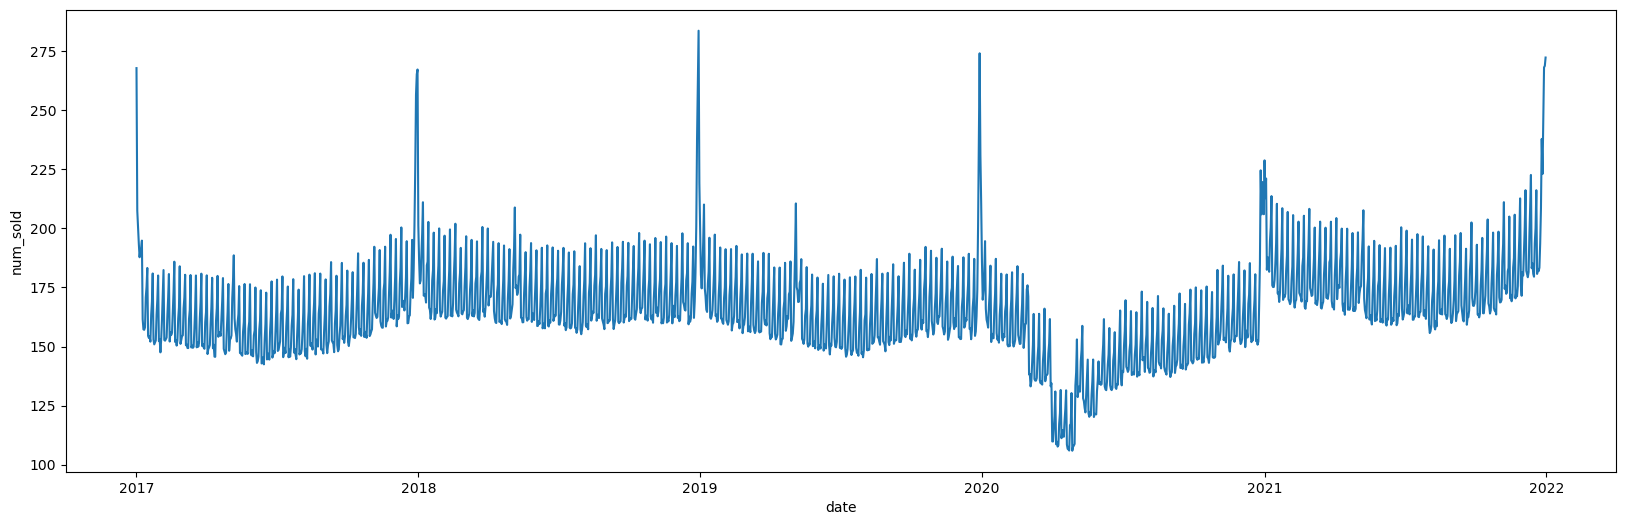

In [23]:
plt.figure(figsize=(20, 6))
sns.lineplot(data = train, x = "date", y = "num_sold", errorbar=None)
plt.show()

* There is a dip in sales in 2020 during COVID. So, data related to 2020 will be dropped

In [24]:
train = train[train["year"] != 2020].reset_index()

In [25]:
train=train.drop('index',axis=1)

In [26]:
#train1=train.copy()

### Preprocessing

In [27]:
train= pd.get_dummies(train, columns=['store', 'product'])
test= pd.get_dummies(test, columns=['store', 'product'])

In [29]:
train.replace({False: 0, True: 1}, inplace=True)
test.replace({False: 0, True: 1}, inplace=True)

In [30]:
test=test.drop('id',axis=1)

In [31]:
train.head()

,date,country,num_sold,year,month,day,weekday,is_month_start,is_month_end,is_year_start,is_year_end,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,2017-01-01,Argentina,63,2017,1,1,6,1,0,1,0,0,1,0,1,0,0,0,0
1,2017-01-01,Argentina,66,2017,1,1,6,1,0,1,0,0,1,0,0,1,0,0,0
2,2017-01-01,Argentina,9,2017,1,1,6,1,0,1,0,0,1,0,0,0,1,0,0
3,2017-01-01,Argentina,59,2017,1,1,6,1,0,1,0,0,1,0,0,0,0,1,0
4,2017-01-01,Argentina,49,2017,1,1,6,1,0,1,0,0,1,0,0,0,0,0,1


In [32]:
test.head()

,date,country,year,month,day,weekday,is_month_start,is_month_end,is_year_start,is_year_end,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,2022-01-01,Argentina,2022,1,1,5,1,0,1,0,0,1,0,1,0,0,0,0
1,2022-01-01,Argentina,2022,1,1,5,1,0,1,0,0,1,0,0,1,0,0,0
2,2022-01-01,Argentina,2022,1,1,5,1,0,1,0,0,1,0,0,0,1,0,0
3,2022-01-01,Argentina,2022,1,1,5,1,0,1,0,0,1,0,0,0,0,1,0
4,2022-01-01,Argentina,2022,1,1,5,1,0,1,0,0,1,0,0,0,0,0,1


In [33]:
print(train.shape)
print(test.shape)

(109500, 19)
(27375, 18)


In [34]:
#source - https://www.kaggle.com/code/iqbalsyahakbar/ps3e19-time-series-for-beginners#Post-processor

def multipliers(predictors, prediction, canada = 1, japan = 1, spain = 1, estonia = 1, argentina = 1):
    prediction[predictors.country == 'Canada'] *= canada
    prediction[predictors.country == 'Japan'] *= japan
    prediction[predictors.country == 'Spain'] *= spain
    prediction[predictors.country == 'Estonia'] *= estonia
    prediction[predictors.country == 'Argentina'] *= argentina
    return prediction

### Model

In [35]:
!pip install pycaret

In [37]:
from pycaret.regression import *
s = setup(data = train, 
          target = 'num_sold', 
          categorical_features = ['country'], 
          ignore_features= ['date'],
          fold_strategy = 'timeseries', 
          fold = 5, 
          normalize = True, normalize_method = 'robust', 
          transform_target = True, 
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,num_sold
2,Target type,Regression
3,Original data shape,"(109500, 19)"
4,Transformed data shape,"(109500, 22)"
5,Transformed train set shape,"(76650, 22)"
6,Transformed test set shape,"(32850, 22)"
7,Ignore features,1
8,Numeric features,16
9,Categorical features,1


In [38]:
bests=compare_models(n_select = 3,sort= 'mae')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,7.3710,190.1125,13.7804,0.9946,0.0551,0.0449,6.1240
xgboost,Extreme Gradient Boosting,7.8239,217.2019,14.7212,0.9938,0.0585,0.0476,3.0020
lightgbm,Light Gradient Boosting Machine,8.6969,283.9461,16.8364,0.9919,0.0652,0.0524,1.4280
rf,Random Forest Regressor,9.5907,377.1111,19.3708,0.9892,0.0753,0.0579,5.1140
et,Extra Trees Regressor,9.9208,401.3896,19.9941,0.9885,0.0784,0.0601,5.5380
knn,K Neighbors Regressor,12.0166,634.0335,25.0883,0.9819,0.0965,0.0723,1.4980
dt,Decision Tree Regressor,12.5266,634.3207,25.0909,0.9819,0.0988,0.0755,0.2900
gbr,Gradient Boosting Regressor,13.4413,676.9570,26.0179,0.9806,0.0993,0.0800,1.9300
lar,Least Angle Regression,21.3199,1587.2943,39.8387,0.9546,0.1663,0.1345,0.2040
br,Bayesian Ridge,21.3205,1587.4470,39.8406,0.9546,0.1663,0.1345,0.2160


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

In [39]:
bests

 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=123, ...),
 LGBMRegressor(random_state=123)]

In [40]:
blend = blend_models(bests)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.9427,238.3159,15.4375,0.9933,0.0590,0.0478
1,7.7574,216.7100,14.7211,0.9939,0.0570,0.0462
2,7.5218,193.2171,13.9003,0.9943,0.0567,0.0461
3,7.4987,193.9324,13.9260,0.9944,0.0562,0.0457
4,7.5084,199.4204,14.1216,0.9943,0.0559,0.0455
Mean,7.6458,208.3192,14.4213,0.9940,0.0570,0.0463
Std,0.1769,17.2305,0.5881,0.0004,0.0011,0.0008


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [41]:
pred = predict_model(blend, data=test)

In [42]:
pred.head()

,date,country,year,month,day,weekday,is_month_start,is_month_end,is_year_start,is_year_end,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,prediction_label
0,2022-01-01,Argentina,2022,1,1,5,1,0,1,0,0,1,0,1,0,0,0,0,38.242715
1,2022-01-01,Argentina,2022,1,1,5,1,0,1,0,0,1,0,0,1,0,0,0,37.031547
2,2022-01-01,Argentina,2022,1,1,5,1,0,1,0,0,1,0,0,0,1,0,0,5.545440
3,2022-01-01,Argentina,2022,1,1,5,1,0,1,0,0,1,0,0,0,0,1,0,35.151639
4,2022-01-01,Argentina,2022,1,1,5,1,0,1,0,0,1,0,0,0,0,0,1,29.158927


In [43]:
pred['num_sold'] = multipliers(pred, np.round(pred["prediction_label"] ) * 1.5, .58, .77, 1., 1.08, 2.82)

In [47]:
pred.columns

Index(['date', 'country', 'year', 'month', 'day', 'weekday', 'is_month_start',
       'is_month_end', 'is_year_start', 'is_year_end', 'store_Kagglazon',
       'store_Kaggle Learn', 'store_Kaggle Store',
       'product_Using LLMs to Improve Your Coding',
       'product_Using LLMs to Train More LLMs',
       'product_Using LLMs to Win Friends and Influence People',
       'product_Using LLMs to Win More Kaggle Competitions',
       'product_Using LLMs to Write Better', 'prediction_label', 'num_sold'],
      dtype='object')

### Submission

In [48]:
sub['num_sold'] = pred['num_sold']

In [49]:
sub.head()

,id,num_sold
0,136950,160.74
1,136951,156.51
2,136952,25.38
3,136953,148.05
4,136954,122.67


In [50]:
sub.to_csv('submission.csv',index=False)